# June30, 2022: BrainIAK tutorial

Paper: https://academic.oup.com/scan/article/14/6/667/5489905
Tutorial: https://github.com/snastase/isc-tutorial

In [1]:
from brainiak.isc import (isc, isfc, bootstrap_isc, permutation_isc, 
                        timeshift_isc, phaseshift_isc, compute_summary_statistic)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, pearsonr, zscore
from scipy.spatial.distance import squareform
from statsmodels.stats.multitest import multipletests
import nibabel as nib

Simulated data shape first subject: (300, 1000) 
i.e., 300 time points and 1000 voxels


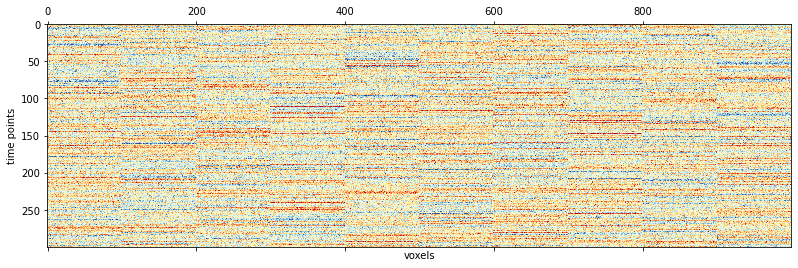

In [2]:
# toy dataset

n_subjects = 20
n_TRs = 300
n_voxels = 1000

# Create simple simulated data with high intersubject correlation
def simulated_timeseries(n_subjects, n_TRs, n_voxels=1, noise=1):
  signal = np.random.randn(n_TRs, n_voxels // 100)
  data = [zscore(np.repeat(signal, 100, axis=1) +
                 np.random.randn(n_TRs, n_voxels) * noise,
                 axis=0)
          for subject in np.arange(n_subjects)]
  return data

# List of subject datasets
data = simulated_timeseries(n_subjects, n_TRs, n_voxels=n_voxels)

# Inspect the shape of one of our simulated datasets
print(f"Simulated data shape first subject: {data[0].shape} "
      f"\ni.e., {data[0].shape[0]} time points and {data[0].shape[1]} voxels")

# Create a simple visualization of the data
plt.matshow(data[0], cmap='RdYlBu_r', vmin=-3, vmax=3)
plt.grid(False)
plt.xlabel('voxels')
plt.ylabel('time points');

In [3]:
# ISC analysis

# Get the time series for a single voxel in two subjects
subject_a = data[0][:, 0]
subject_b = data[1][:, 0]

# Check the shape of these mini-datasets
print(f"Subject A, first voxel, shape = {subject_a.shape} "
      f"\nSubject B, first voxel, shape = {subject_b.shape}")

# Combine these into a list
both_subjects = [subject_a, subject_b]

# Compute the ISC for this voxel across the two subjects
iscs = isc(both_subjects, pairwise=True)
print(f"ISC for first voxel across subjects A and B = {iscs[0]}")

# NB: even for a single voxel, the output ISC is shaped to 
# to accommodate an n_ISCs x n_voxels matrix
print(f"ISC output shape = {iscs.shape}"
      f"\ni.e., {iscs.shape[0]} ISC value(s) by {iscs.shape[0]} voxel(s)")

# Check that ISC output matches of other correlation functions in python
numpy_corrcoef = np.corrcoef(subject_a, subject_b)[0, 1]

scipy_pearsonr = pearsonr(subject_a, subject_b)[0]

print(f"BrainIAK ISC = {iscs[0]:.6f}"
      f"\nNumpy's correlation = {numpy_corrcoef:.6f}"
      f"\nScipy's correlation = {scipy_pearsonr:.6f}")
assert np.isclose(iscs, numpy_corrcoef) and np.isclose(iscs, scipy_pearsonr)

Subject A, first voxel, shape = (300,) 
Subject B, first voxel, shape = (300,)
ISC for first voxel across subjects A and B = 0.49804642802182514
ISC output shape = (1,)
i.e., 1 ISC value(s) by 1 voxel(s)
BrainIAK ISC = 0.498046
Numpy's correlation = 0.498046
Scipy's correlation = 0.498046


In [4]:
# Import logging module and set level to INFO
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

# Re-run the previous ISC analyses to see logged info
iscs = isc(both_subjects, pairwise=True)

# Set logging back to default level of WARNING
logging.getLogger().setLevel(logging.WARNING)

INFO:brainiak.utils.utils:Assuming 2 subjects with 300 time points and 1 voxel(s) or ROI(s) for ISC analysis.
INFO:brainiak.isc:Only two subjects! Simply computing Pearson correlation.
INFO:brainiak.isc:ISC computation will tolerate all NaNs when averaging


## ISC

In [5]:
# Pairwise approach across all subjects and voxels
iscs = isc(data, pairwise=True)

# Check shape of output ISC values
print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"pairs and {iscs.shape[1]} voxels"
      f"\nMinimum ISC = {np.amin(iscs):.3f}; "
      f"maximum ISC = {np.amax(iscs):.3f}")

ISC values shape = (190, 1000) 
i.e., 190 pairs and 1000 voxels
Minimum ISC = 0.277; maximum ISC = 0.676


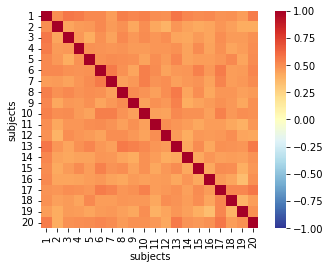

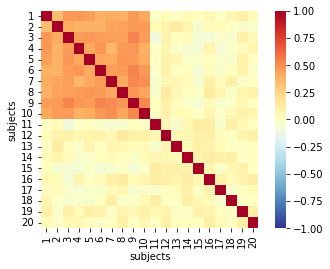

In [6]:
# Visualize the correlation matrix for one voxel
isc_matrix = squareform(iscs[:, 0])
np.fill_diagonal(isc_matrix, 1)
sns.heatmap(isc_matrix, cmap="RdYlBu_r", vmin=-1, vmax=1, square=True, 
            xticklabels=range(1, 21), yticklabels=range(1, 21))
plt.xlabel('subjects')
plt.ylabel('subjects')
plt.show()

# Create noisier data
noisy_data = np.dstack((np.dstack((
    simulated_timeseries(n_subjects // 2, n_TRs,
                         n_voxels=n_voxels, noise=1))),
                        np.dstack((
    simulated_timeseries(n_subjects // 2, n_TRs,
                         n_voxels=n_voxels, noise=5)))))

# Recompute ISC and visualize data with noisy subjects
noisy_iscs = isc(noisy_data, pairwise=True)
isc_matrix = squareform(noisy_iscs[:, 0])
np.fill_diagonal(isc_matrix, 1)
sns.heatmap(isc_matrix, cmap="RdYlBu_r", vmin=-1, vmax=1, square=True, 
            xticklabels=range(1, 21), yticklabels=range(1, 21))
plt.xlabel('subjects')
plt.ylabel('subjects')
plt.show()

In [7]:
# Leave-one-out approach
iscs = isc(data, pairwise=False)

# Check shape of output ISC values
print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"left-out subjects and {iscs.shape[1]} voxel(s)"
      f"\nMinimum ISC = {np.amin(iscs):.3f}; "
      f"maximum ISC = {np.amax(iscs):.3f}")

ISC values shape = (20, 1000) 
i.e., 20 left-out subjects and 1000 voxel(s)
Minimum ISC = 0.553; maximum ISC = 0.794


In [8]:
# Input a list of subjects (same as before)
iscs = isc(data, pairwise=False)

# Stack subjects in 3rd-dimension and recompute ISC
data_stack = np.dstack(data)
print(f"Stacked data shape = {data_stack.shape}"
      f"\ni.e., {data_stack.shape[0]} time points, {data_stack.shape[1]} "
      f"voxels, and {data_stack.shape[2]} subjects")

# Input stacked numpy array
iscs_from_stack = isc(data_stack, pairwise=False)

# Make sure the ISC outputs are the same
assert np.array_equal(iscs, iscs_from_stack)

Stacked data shape = (300, 1000, 20)
i.e., 300 time points, 1000 voxels, and 20 subjects


In [9]:
# Compute mean leave-one-out ISC
iscs = isc(data, pairwise=False, summary_statistic='mean')

print(f"ISC values shape = {iscs.shape} \ni.e., the mean value across "
      f"left-out subjects for {iscs.shape[0]} voxel(s)"
      f"\nMean ISC for first voxel = {iscs[0]:.3f}")

# Compute median leave-one-out ISC
iscs = isc(data, pairwise=False, summary_statistic='median')

print(f"ISC values shape = {iscs.shape} \ni.e., the median value across "
      f"left-out subjects for {iscs.shape[0]} voxel(s)"
      f"\nMedian ISC for first voxel = {iscs[0]:.3f}")

ISC values shape = (1000,) 
i.e., the mean value across left-out subjects for 1000 voxel(s)
Mean ISC for first voxel = 0.667
ISC values shape = (1000,) 
i.e., the median value across left-out subjects for 1000 voxel(s)
Median ISC for first voxel = 0.665


## Statistics on ISC

In [10]:
# Phase randomization using pairwise approach (takes a couple minutes)
observed, p, distribution = phaseshift_isc(data, pairwise=True,
                                           summary_statistic='median',
                                           n_shifts=200)

In [11]:
# Inspect shape of null distribution
print(f"Null distribution shape = {distribution.shape}"
      f"\ni.e., {distribution.shape[0]} randomizations "
      f"and {distribution.shape[1]} voxels")

# Get actual ISC value and p-value for first voxel
print(f"Actual observed ISC value for first voxel = {observed[0]:.3f},"
      f"\np-value from randomization test = {p[0]:.3f}")

Null distribution shape = (200, 1000)
i.e., 200 randomizations and 1000 voxels
Actual observed ISC value for first voxel = 0.470,
p-value from randomization test = 0.005


In [12]:
# Circular time-shift using pairwise approach (takes a couple minutes)
observed, p, distribution = timeshift_isc(data, pairwise=True,
                                          summary_statistic='median',
                                          n_shifts=200)

In [13]:
# Inspect shape of null distribution
print(f"Null distribution shape = {distribution.shape}"
      f"\ni.e., {distribution.shape[0]} randomizations "
      f"and {distribution.shape[1]} voxels")

# Get actual ISC value and p-value for first voxel
print(f"Actual observed ISC value for first voxel = {observed[0]:.3f},"
      f"\np-value from randomization test = {p[0]:.3f}")

Null distribution shape = (200, 1000)
i.e., 200 randomizations and 1000 voxels
Actual observed ISC value for first voxel = 0.470,
p-value from randomization test = 0.005


In [14]:
# Compute ISCs and then run bootstrap hypothesis test on ISCs
iscs = isc(data, pairwise=True, summary_statistic=None)
observed, ci, p, distribution = bootstrap_isc(iscs, pairwise=True,
                                              ci_percentile=95,
                                              summary_statistic='median',
                                              n_bootstraps=200)

In [15]:
# Inspect shape of null distribution
print(f"Null distribution shape = {distribution.shape}"
      f"\ni.e., {distribution.shape[0]} bootstraps "
      f"and {distribution.shape[1]} voxels")

# Get actual ISC value and p-value for first voxel
print(f"Actual observed ISC value for first voxel = {observed[0]:.3f},"
      f"\np-value from bootstrap hypothesis test = {p[0]:.3f}")

Null distribution shape = (200, 1000)
i.e., 200 bootstraps and 1000 voxels
Actual observed ISC value for first voxel = 0.470,
p-value from bootstrap hypothesis test = 0.005


In [16]:
# Compute ISCs and then run one-sample permutation test on ISCs
iscs = isc(data, pairwise=True, summary_statistic=None)
observed, p, distribution = permutation_isc(iscs, pairwise=True,
                                            summary_statistic='median',
                                            n_permutations=200)

In [17]:
# Inspect shape of null distribution
print(f"Null distribution shape = {distribution.shape}"
      f"\ni.e., {distribution.shape[0]} permutations "
      f"and {distribution.shape[1]} voxels")

# Get actual ISC value and p-value for first voxel
print(f"Actual observed ISC value for first voxel = {observed[0][0]:.3f},"
      f"\np-value from permutation test = {p[0]:.3f}")

Null distribution shape = (200, 1000)
i.e., 200 permutations and 1000 voxels
Actual observed ISC value for first voxel = 0.470,
p-value from permutation test = 0.005


In [18]:
# Note that with few subjects, an exact test is performed
data_n6 = data[:6]
iscs = isc(data_n6, pairwise=True, summary_statistic=None)
observed, p, distribution = permutation_isc(iscs, pairwise=True,
                                            summary_statistic='median',
                                            n_permutations=200)

In [19]:
# Create data with noisy subset of subjects
noisy_data = np.dstack((np.dstack((
    simulated_timeseries(n_subjects // 2, n_TRs,
                         n_voxels=n_voxels, noise=1))),
                        np.dstack((
    simulated_timeseries(n_subjects // 2, n_TRs,
                         n_voxels=n_voxels, noise=5)))))

# Create group_assignment variable with group labels
group_assignment = [1]*10 + [2]*10
print(f"Group assignments: \n{group_assignment}")

# Compute ISCs and then run two-sample permutation test on ISCs
iscs = isc(noisy_data, pairwise=True, summary_statistic=None)
observed, p, distribution = permutation_isc(iscs,
                                            group_assignment=group_assignment,
                                            pairwise=True,
                                            summary_statistic='median',
                                            n_permutations=200)

Group assignments: 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [20]:
# Inspect shape of null distribution
print(f"Null distribution shape = {distribution.shape}"
      f"\ni.e., {distribution.shape[0]} permutations "
      f"and {distribution.shape[1]} voxels")

# Get actual ISC value and p-value for first voxel
print(f"Actual observed group difference in ISC values "
      f"for first voxel = {observed[0]:.3f},"
      f"\np-value from permutation test = {p[0]:.3f}")

Null distribution shape = (200, 1000)
i.e., 200 permutations and 1000 voxels
Actual observed group difference in ISC values for first voxel = 0.428,
p-value from permutation test = 0.005


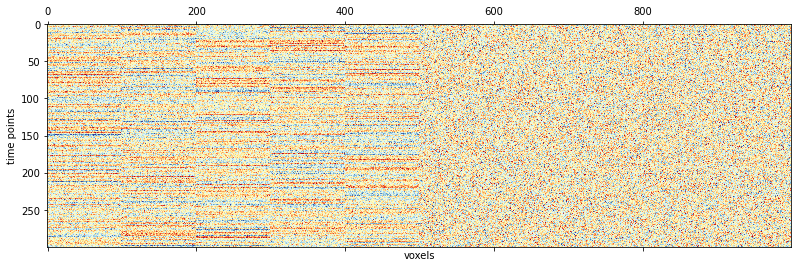

In [21]:
# Create data with where half of voxels are noisy
noisy_data = np.hstack((np.dstack((
    simulated_timeseries(n_subjects, n_TRs,
                         n_voxels=n_voxels // 2, noise=1))),
                        np.dstack((
    simulated_timeseries(n_subjects, n_TRs,
                         n_voxels=n_voxels // 2, noise=9)))))

# Visualize data for first subject where half of voxels are noisy
plt.matshow(noisy_data[..., 0], cmap='RdYlBu_r', vmin=-3, vmax=3)
plt.grid(False)
plt.xlabel('voxels')
plt.ylabel('time points');

In [22]:
# Compute ISCs and then run bootstrap hypothesis test on ISCs
# using a realistic number of permutations (takes a few minutes)
iscs = isc(noisy_data, pairwise=True, summary_statistic=None)
observed, ci, p, distribution = bootstrap_isc(iscs, pairwise=True,
                                              ci_percentile=95,
                                              summary_statistic='median',
                                              n_bootstraps=1000)

In [23]:
# Get q-values (i.e., FDR-controlled p-values) using statsmodels
q = multipletests(p, method='fdr_by')[1]

# We can also convert these q-values to z-values
z = np.abs(norm.ppf(q))

# Also get significant voxels with and without correction
corrected = q[np.newaxis, :] < .05
uncorrected = p[np.newaxis, :] < .05

# Count significant voxels before and after correction
print(f'{np.sum(uncorrected)} "significant" voxels before correction for '
      f"multiple tests; {np.sum(corrected)} significant voxels after "
      f"controlling FDR at .05")

678 "significant" voxels before correction for multiple tests; 528 significant voxels after controlling FDR at .05


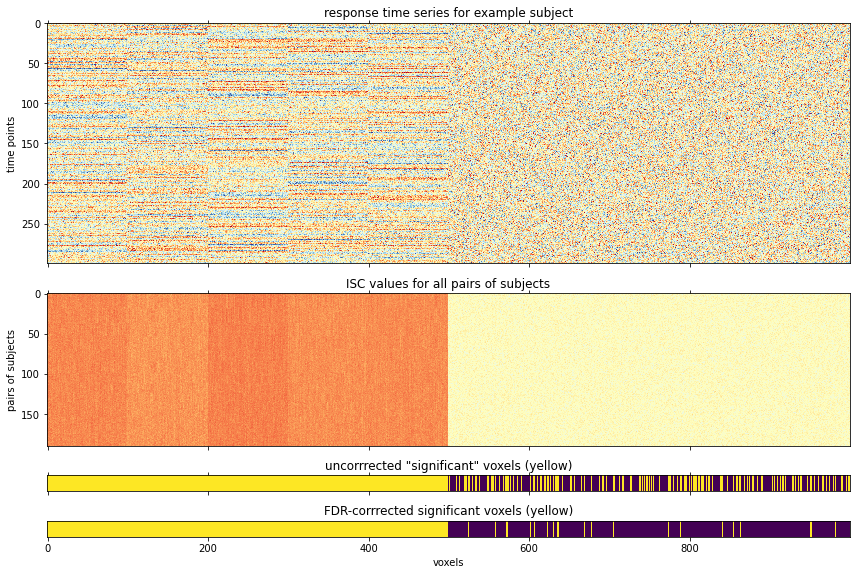

In [24]:
# Set up grid of subplots for visualizing voxel values and significance
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(12, 8),
                                         sharex=True,
                                         gridspec_kw={'height_ratios':
                                                      [300, 190, 20, 20]})

# Visualize data for first subject where half of voxels are noisy
ax0.matshow(noisy_data[..., 0], cmap='RdYlBu_r', vmin=-3, vmax=3)
ax0.grid(False)
ax0.set_ylabel('time points')
ax0.set_title('response time series for example subject', y=1)

# Visualize ISC values across all pairs of subjects
ax1.matshow(iscs, cmap='RdYlBu_r', vmin=-1, vmax=1)
ax1.grid(False)
ax1.set_ylabel('pairs of subjects')
ax1.set_title('ISC values for all pairs of subjects', y=1)

# Visualize uncorrected and corrected significant voxels
ax2.matshow(np.repeat(uncorrected, 20, axis=0),
            cmap='viridis',vmin=0, vmax=1)
ax2.grid(False)
ax2.set_yticks([])
ax2.set_title('uncorrrected "significant" voxels (yellow)')

ax3.matshow(np.repeat(corrected, 20, axis=0),
            cmap='viridis',vmin=0, vmax=1)
ax3.grid(False)
ax3.set_xlabel('voxels')
ax3.xaxis.tick_bottom()
ax3.set_yticks([])
ax3.set_title('FDR-corrrected significant voxels (yellow)')
plt.tight_layout()

## ISFC

In [25]:
# Compute ISFCs using leave-one-out approach
isfcs, iscs = isfc(data, pairwise=False, vectorize_isfcs=True)

# Check shape of output ISFC values
print(f"ISFC output shape = {isfcs.shape}\ni.e., {isfcs.shape[0]} "
      f"left-out subjects by {isfcs.shape[1]} connections (i.e., voxel pairs)"
      f"\nISCs output shape = {iscs.shape}\ni.e., {iscs.shape[0]} "
      f"left-out subjects by {iscs.shape[1]} voxels")

ISFC output shape = (20, 499500)
i.e., 20 left-out subjects by 499500 connections (i.e., voxel pairs)
ISCs output shape = (20, 1000)
i.e., 20 left-out subjects by 1000 voxels


In [26]:
# Compute ISFCs using leave-one-out approach
isfcs = isfc(data, pairwise=False, vectorize_isfcs=False)

# Check shape of output ISFC values
print(f"ISFC output shape = {isfcs.shape}\ni.e., {isfcs.shape[0]} "
      f"left-out subjects by {isfcs.shape[1]} voxels by {isfcs.shape[2]} "
      "voxels")

ISFC output shape = (20, 1000, 1000)
i.e., 20 left-out subjects by 1000 voxels by 1000 voxels


In [27]:
# Compute ISFCs using leave-one-out approach with mean
isfcs, iscs = isfc(data, pairwise=False, summary_statistic='mean',
                   vectorize_isfcs=True)

# Check shape of output ISFC values
print(f"Mean ISFC output shape = {isfcs.shape}\ni.e., {isfcs.shape[0]} "
      f"connections (i.e., voxel pairs)"
      f"\nMean ISC output shape = {iscs.shape}\ni.e., {iscs.shape[0]} "
      "voxels")

Mean ISFC output shape = (499500,)
i.e., 499500 connections (i.e., voxel pairs)
Mean ISC output shape = (1000,)
i.e., 1000 voxels


In [28]:
from brainiak.isc import squareform_isfc

# Start with square (redundant) ISFCs and check shape
isfcs_sq = isfc(data, pairwise=False, vectorize_isfcs=False)
print(f"Square (redundant) ISFCs shape: {isfcs_sq.shape}")

# Convert these directly to condensed ISFCs (and ISCs)
isfcs_c, iscs = squareform_isfc(isfcs_sq)
print(f"Condensed ISFCs shape: {isfcs_c.shape}, "
      f"ISCs shape: {iscs.shape}")

# Convert these directly back to redundant ISFCs
isfcs_r = squareform_isfc(isfcs_c, iscs)
print(f"Converted redundant ISFCs shape: {isfcs_r.shape}")

# Check that they are identical to the original square ISFCs
assert np.array_equal(isfcs_sq, isfcs_r)

Square (redundant) ISFCs shape: (20, 1000, 1000)
Condensed ISFCs shape: (20, 499500), ISCs shape: (20, 1000)
Converted redundant ISFCs shape: (20, 1000, 1000)


In [29]:
# Get ISC values directly from ISFC matrix
isfcs, iscs = isfc(data, pairwise=False, vectorize_isfcs=True)

# Check that these are the same as conventional ISCs
assert np.allclose(iscs, isc(data))

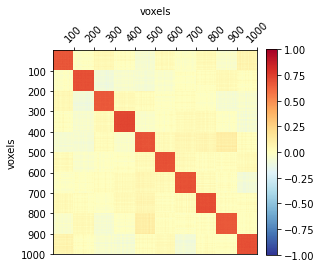

In [30]:
# Recompute mean ISFCs
isfcs, iscs = isfc(data, pairwise=False, summary_statistic='mean',
                   vectorize_isfcs=True)

# Convert these to a square representation
isfcs = squareform_isfc(isfcs, iscs)

# Visual mean ISFC matrix
plt.matshow(isfcs, cmap="RdYlBu_r", vmin=-1, vmax=1)
plt.grid(False)
plt.xticks(np.arange(0, 1001, 100)[1:], np.arange(100, 1001, 100),
           rotation=45)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.yticks(np.arange(0, 1001, 100)[1:], np.arange(100, 1001, 100))
plt.xlabel('voxels')
plt.ylabel('voxels')
ax = plt.gca()
plt.colorbar(fraction=0.046, pad=0.04);

In [31]:
# Create more structured simulated data with 7 "networks";
# don't worry about the details
from scipy.ndimage import gaussian_filter1d

def structured_timeseries(n_subjects, n_TRs, n_voxels=1000, noise=1):
  signals = np.random.randn(n_TRs, 3)
  networks = np.column_stack((signals + np.random.randn(n_TRs, 3) * noise,
                              signals[:, 0] + np.random.randn(n_TRs) * noise,
                              signals[:, 0] + np.random.randn(n_TRs) * noise,
                              -signals[:, 2] + np.random.randn(n_TRs) * noise,
                              signals[:, 2] + np.random.randn(n_TRs) * noise))
  networks = networks[:, [0, 3, 4, 5, 1, 2, 6]]
  six = np.random.randint(n_voxels // 20, n_voxels // 6, 6)
  seven = np.append(six, (n_voxels - np.sum(six)))
  voxels = np.column_stack([np.tile(network[:, np.newaxis], (1, extent))
                            for network, extent in zip(networks.T, seven)])
  areas = [0] + sorted(np.random.randint(0, 1000, 16))
  areas = np.diff(areas).tolist() + [(1000 - areas[-1])]
  noise_sources = np.random.randn(n_TRs, 7)
  structured_noise = np.column_stack([np.tile(
      (noise_sources[:, np.random.choice(range(7))] *
       np.random.choice([-1, 1, 1, 1]))[:, np.newaxis],
                                              (1, extent)) 
                                      for extent in areas])
  voxels = gaussian_filter1d(voxels, 8.0, axis=0)
  structured_noise = gaussian_filter1d(structured_noise, 8.0, axis=0)
  data = []
  for s in np.arange(n_subjects):
    data.append(voxels + structured_noise * noise * .2 +
                np.random.randn(n_TRs, n_voxels) * noise * 1.35)

  data = np.dstack(data)
  return data

structured_data = structured_timeseries(n_subjects, n_TRs)

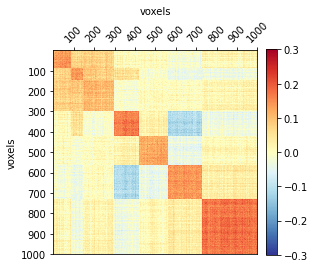

In [32]:
# Compute ISFCs using leave-one-out approach with mean
isfcs, iscs = isfc(structured_data, pairwise=False, summary_statistic='mean',
                   vectorize_isfcs=True)

# Convert these to a square representation
isfcs = squareform_isfc(isfcs, iscs)

# Visual mean ISFC matrix
plt.matshow(isfcs, cmap="RdYlBu_r", vmin=-.3, vmax=.3)
plt.grid(False)
plt.xticks(np.arange(0, 1001, 100)[1:], np.arange(100, 1001, 100),
           rotation=45)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.yticks(np.arange(0, 1001, 100)[1:], np.arange(100, 1001, 100))
plt.xlabel('voxels')
plt.ylabel('voxels')
ax = plt.gca()
plt.colorbar(fraction=0.046, pad=0.04);